In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scripts.data_loader import load_caravan
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [9]:
# ---------------------------
# 1) Load data and names
# ---------------------------
train, test, X, y, TARGET = load_caravan(data_dir="./data")
print("Train shape:", train.shape)
print("Test shape:", test.shape)

Train shape: (5822, 86)
Test shape: (4000, 85)


In [10]:
# ---------- stratified split ----------
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

print("Train/Val sizes:", X_train.shape, X_val.shape)
print("Positive rate train/val:", round(y_train.mean(),4), round(y_val.mean(),4))

Train/Val sizes: (4657, 85) (1165, 85)
Positive rate train/val: 0.0597 0.0601


In [11]:
# 1) Scale features
scaler = StandardScaler(with_mean=False)
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)

# 2) Fit logistic regression
logit = LogisticRegression(
    penalty="l2",            # type of regularization
    C=1.0,                   # inverse of regularization strength
    max_iter=2000,           # maximum iterations
    class_weight="balanced", # handle class imbalance by giving more weight to minority class 
    random_state=42
)
logit.fit(X_train_scaled, y_train)

# 3) Predictions
proba_val = logit.predict_proba(X_val_scaled)[:, 1]  # probability of class 1
preds_val = logit.predict(X_val_scaled)              # hard predictions (0/1)

print("First 10 predicted probabilities:", proba_val[:10])
print("First 10 predicted labels:", preds_val[:10])


First 10 predicted probabilities: [0.36258832 0.89583635 0.40847078 0.79369429 0.05451557 0.32364035
 0.09118492 0.42176017 0.24575399 0.61697198]
First 10 predicted labels: [0 1 0 1 0 0 0 0 0 1]


ROC-AUC: 0.7429
PR-AUC : 0.1591

Classification report @ threshold = 0.5
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1095
           1       0.13      0.67      0.22        70

    accuracy                           0.71      1165
   macro avg       0.55      0.69      0.52      1165
weighted avg       0.92      0.71      0.78      1165

Confusion matrix:
 [[776 319]
 [ 23  47]]
Precision@Top5%: 0.2241
Precision@Top10%: 0.1983


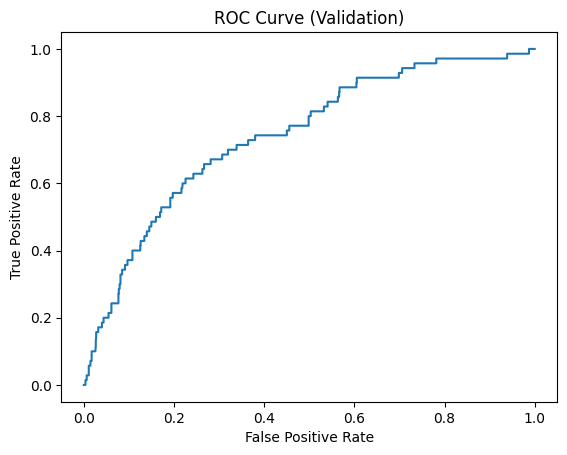

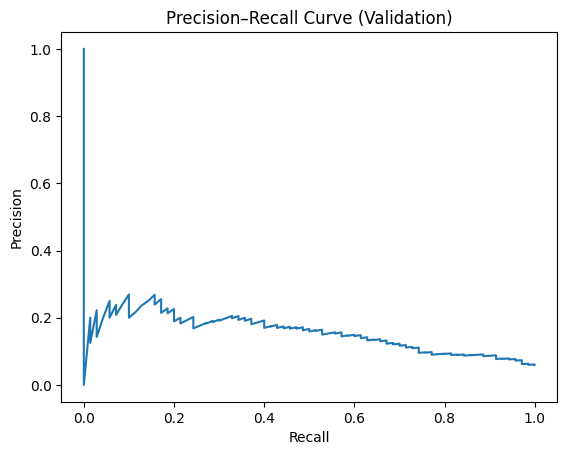

In [12]:
from sklearn.metrics import (
    roc_auc_score, average_precision_score, classification_report,
    confusion_matrix, roc_curve, precision_recall_curve
)
import numpy as np
import matplotlib.pyplot as plt

# 1) Probabilities & predictions
proba_val = logit.predict_proba(X_val_scaled)[:, 1]  # P(y=1)
preds_val = logit.predict(X_val_scaled)              # hard labels @ 0.5

# 2) Core metrics
roc = roc_auc_score(y_val, proba_val)
pra = average_precision_score(y_val, proba_val)  # PR-AUC (area under PR curve)
print("ROC-AUC:", round(roc, 4))
print("PR-AUC :", round(pra, 4))

print("\nClassification report @ threshold = 0.5")
print(classification_report(y_val, preds_val, zero_division=0))

cm = confusion_matrix(y_val, preds_val)
print("Confusion matrix:\n", cm)

# 3) Precision@Top-k% (ranking quality for campaigns)
def precision_at_k(y_true, scores, k=0.05):
    n = len(scores)
    top = max(1, int(k * n))
    idx = np.argsort(-scores)[:top]     # indices of top-k% highest probabilities
    return float(y_true.iloc[idx].mean())

for k in [0.05, 0.10]:
    p_at_k = precision_at_k(y_val, proba_val, k)
    print(f"Precision@Top{int(k*100)}%:", round(p_at_k, 4))

# 4) Curves (each in its own figure)
fpr, tpr, _ = roc_curve(y_val, proba_val)
plt.figure()
plt.plot(fpr, tpr)
plt.title("ROC Curve (Validation)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.show()

precision, recall, _ = precision_recall_curve(y_val, proba_val)
plt.figure()
plt.plot(recall, precision)
plt.title("Precision–Recall Curve (Validation)")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.show()


ROC-AUC = 0.7429 Quality of ranking across all thresholds. 0.5 = random; 1.0 = perfect. Your model meaningfully ranks likely buyers above non-buyers.

PR-AUC = 0.1591 Area under the Precision–Recall curve. This is the right lens for imbalanced data (positives ≈ 6%). A naive baseline would be ≈ the positive rate (~0.06). 0.1591 ≫ 0.06 = solid lift: when you focus on the top-scored customers, precision is much better than random.

At the default threshold (0.5)

Confusion matrix TN=776 FP=319 FN= 23 TP= 47

Class 1 (buyers)

Recall = 0.67 (47/70): the model finds 67% of the actual buyers.

Precision = 0.13 (47/(47+319)): among predicted buyers, only 13% truly buy.

F1 = 0.22: harmonic mean of the two; low because precision is low.

Class 0 (non-buyers)

Precision = 0.97, Recall = 0.71, F1 ≈ 0.82 → model is strong at recognizing non-buyers.

Accuracy = 0.71 Not very informative under class imbalance (a “predict all 0s” model would already be ≈94% accurate here, so accuracy isn’t the right KPI).

Why precision is low @ 0.5: the dataset is highly imbalanced; using a 0.5 cut-off isn’t optimal for marketing targeting. You care more about ranking the top prospects than about a single threshold.

In [13]:
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, average_precision_score, classification_report, confusion_matrix
import numpy as np

# 1) Define model (same settings as before, except C will be tuned)
base_logit = LogisticRegression(
    penalty="l2",
    solver="lbfgs",
    class_weight="balanced",
    max_iter=2000,
    random_state=42
)

# 2) Small grid over C (inverse of regularization strength)
param_grid = {
    "C": [0.01, 0.1, 1.0, 3.0, 10.0]
}

# 3) 5-fold stratified CV, scored by PR-AUC (average precision)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=base_logit,
    param_grid=param_grid,
    scoring="average_precision",  # PR-AUC
    cv=cv,
    n_jobs=-1,
    refit=True,                   # refit on full training split with best params
    return_train_score=False
)

# IMPORTANT: tune only on the TRAIN split to avoid leakage
grid.fit(X_train_scaled, y_train)

print("Best params:", grid.best_params_)
print("Best CV PR-AUC:", round(grid.best_score_, 4))

best_logit = grid.best_estimator_

# 4) Evaluate best model on the validation split
proba_val = best_logit.predict_proba(X_val_scaled)[:, 1]
preds_val  = best_logit.predict(X_val_scaled)

roc = roc_auc_score(y_val, proba_val)
pra = average_precision_score(y_val, proba_val)
print("\nValidation ROC-AUC:", round(roc, 4))
print("Validation PR-AUC :", round(pra, 4))

print("\nClassification report @ 0.5")
print(classification_report(y_val, preds_val, zero_division=0))

cm = confusion_matrix(y_val, preds_val)
print("Confusion matrix:\n", cm)

# 5) Precision@Top-k% (useful for marketing targeting)
def precision_at_k(y_true, scores, k=0.05):
    n = len(scores)
    top = max(1, int(k*n))
    idx = np.argsort(-scores)[:top]
    return float(y_true.iloc[idx].mean())

for k in [0.05, 0.10]:
    print(f"Precision@Top{int(k*100)}%:",
          round(precision_at_k(y_val, proba_val, k), 4))

Best params: {'C': 0.01}
Best CV PR-AUC: 0.1547

Validation ROC-AUC: 0.7636
Validation PR-AUC : 0.1781

Classification report @ 0.5
              precision    recall  f1-score   support

           0       0.97      0.71      0.82      1095
           1       0.13      0.70      0.22        70

    accuracy                           0.71      1165
   macro avg       0.55      0.70      0.52      1165
weighted avg       0.92      0.71      0.78      1165

Confusion matrix:
 [[775 320]
 [ 21  49]]
Precision@Top5%: 0.2414
Precision@Top10%: 0.1983


What we tuned: Only C (regularization strength). It’s the key lever for Logistic Regression.

Smaller C ⇒ stronger regularization (simpler model, less overfit).

Larger C ⇒ weaker regularization (more flexible model).

Why PR-AUC for scoring: Positives are rare (~6%). PR-AUC focuses on precision/recall trade-off, so improvements here are meaningful for our marketing use case.

Why CV: Stratified 5-fold CV estimates generalization more robustly than a single split.

Why refit=True on train split only: Avoids peeking at validation (no leakage).